In [1]:
import argparse
import os
import struct
import time
from pathlib import Path
from typing import List, Optional, Callable, Sequence, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# For visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tqdm

from torch.cuda.amp import GradScaler, autocast


print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
LEAF_DIM = 8  # Dimension of each leaf in the VDB dataset
class VDBLeafDataset(Dataset):
    def __init__(
            self,
            npy_files: Sequence[str | Path],
            transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
            *,
            include_origins: bool = False,
            origins_root: str | Path | None = None,
            origins_suffix: str = "._origins.npy",
    ) -> None:
        super().__init__()
        self.transform = transform
        self.include_origins = include_origins
        self.buffer = torch.empty(0)  # Pre-allocate later

        # Precompute offsets and mmap files
        self.arrays = []
        self.origin_arrays = [] if include_origins else None
        lengths = []

        for f in npy_files:
            arr = np.load(f, mmap_mode="r")
            if arr.shape[1:] != (LEAF_DIM, LEAF_DIM, LEAF_DIM):
                raise ValueError(f"{f}: invalid shape {arr.shape}")
            self.arrays.append(arr)
            lengths.append(arr.shape[0])

            if include_origins:
                origin_path = Path(origins_root or f).with_suffix(origins_suffix)
                if not origin_path.exists():
                    raise FileNotFoundError(origin_path)
                self.origin_arrays.append(np.load(origin_path, mmap_mode="r"))

        self.file_offsets = np.cumsum([0] + lengths)
        self.total_leaves = int(self.file_offsets[-1])

    def __len__(self) -> int:
        return self.total_leaves

    def __getitem__(self, idx: int):
        file_idx = np.searchsorted(self.file_offsets, idx, side="right") - 1
        local_idx = idx - self.file_offsets[file_idx]

        # Use buffer to avoid allocation
        leaf = torch.from_numpy(
            self.arrays[file_idx][local_idx].astype(np.float32, copy=False)
        ).unsqueeze(0)  # Add channel dim

        if self.transform:
            leaf = self.transform(leaf)

        if self.include_origins:
            origin = torch.from_numpy(
                self.origin_arrays[file_idx][local_idx].astype(np.int32, copy=False)
            )
            return leaf, origin
        return leaf


In [3]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int,
                 commitment_cost: float, decay: float = 0.99, eps: float = 1e-5):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.eps = eps

        # Initialize embeddings (small variance + normalize)
        embed = torch.randn(num_embeddings, embedding_dim)
        embed = F.normalize(embed, dim=1)

        self.register_buffer('embedding', embed)
        self.register_buffer('cluster_size', torch.ones(num_embeddings))
        self.register_buffer('embed_avg', embed.clone().detach())

    def forward(self, x) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        D = self.embedding_dim

        # Build the permutation list explicitly: [0, 2, 3, …, n, 1]
        permute_fwd: List[int] = [0] + list(range(2, x.dim())) + [1]

        permuted_x = torch.permute(x, permute_fwd).contiguous()
        flat = permuted_x.view(-1, D)

        # Compute distances
        distances = (
                torch.sum(flat ** 2, dim=1, keepdim=True)
                + torch.sum(self.embedding ** 2, dim=1)
                - 2 * torch.mm(flat, self.embedding.t())
        )

        # Get nearest codes
        encoding_indices = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).type(flat.dtype)

        # Quantize
        quantized = encodings @ self.embedding
        quantized = quantized.view(permuted_x.shape)

        permute_back: List[int] = [0, x.dim() - 1] + list(range(1, x.dim() - 1))
        quantized = torch.permute(quantized, permute_back)

        # EMA updates
        if self.training:
            with torch.no_grad():
                encodings_sum = encodings.sum(0)
                self.cluster_size.mul_(self.decay).add_(encodings_sum, alpha=1 - self.decay)

                dw = encodings.t() @ flat.detach()
                self.embed_avg.mul_(self.decay).add_(dw, alpha=1 - self.decay)

                n = self.cluster_size.clamp(min=self.eps)
                self.embedding.copy_(self.embed_avg / n.unsqueeze(1))

        commitment_loss = self.commitment_cost * F.mse_loss(x, quantized.detach())
        loss = commitment_loss

        # Straight-through estimator
        quantized = x + (quantized - x).detach()

        # Perplexity
        avg_probs = encodings.mean(0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, loss, perplexity


class Encoder(nn.Module):
    def __init__(self, in_channels, embedding_dim):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            # 8³ → 4³
            nn.Conv3d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),

            # Refine at 4³
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),

            # Final projection
            nn.Conv3d(64, embedding_dim, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, embedding_dim, out_channels):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            # Expand from embedding_dim
            nn.Conv3d(embedding_dim, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),

            # 4³ → 8³
            nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),

            # Final reconstruction
            nn.Conv3d(32, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)
    
    
class VQVAE(nn.Module):
    def __init__(self, in_channels, embedding_dim, num_embeddings, commitment_cost):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(in_channels, embedding_dim)
        self.quantizer = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim, in_channels)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, perplexity = self.quantizer(z)
        x_recon = self.decoder(quantized)
        return z, x_recon, vq_loss, perplexity

    @torch.jit.export
    def encode(self, x) -> torch.Tensor:
        z = self.encoder(x)

        shape = list(z.shape)  # List[int]
        B, D = shape[0], shape[1]
        spatial = shape[2:]

        permute_fwd = [0] + list(range(2, z.dim())) + [1]
        flat_z = (torch.permute(z, permute_fwd)
                  .contiguous()
                  .view(-1, D)
                  )

        distances = (torch.sum(flat_z ** 2, dim=1, keepdim=True)
                     + torch.sum(self.quantizer.embedding ** 2, dim=1)
                     - 2 * torch.matmul(flat_z, self.quantizer.embedding.t()))
        indices = torch.argmin(distances, dim=1)

        return indices.view([B] + spatial)

    @torch.jit.export
    def decode(self, indices):
        quantized_vectors = F.embedding(indices, self.quantizer.embedding)
        permute_back = [0, quantized_vectors.dim() - 1] + list(range(1, quantized_vectors.dim() - 1))
        quantized_for_decoder = torch.permute(quantized_vectors, permute_back)
        x_recon = self.decoder(quantized_for_decoder)
        return x_recon

    def get_codebook(self) -> torch.Tensor:
        return self.quantizer.embedding
    
    
    def check_and_reset_dead_codes(self, encoder_outputs):
        """
        Checks for and resets dead codes in the quantizer's codebook by
        resampling them from the given batch of encoder outputs.
        """
        # Ensure you are on the correct device
        device = self.quantizer.embedding.device
        
        # Use .detach() to ensure this operation is not part of the autograd graph
        flat_z = self.encoder_outputs_to_flat(encoder_outputs.detach())

        with torch.no_grad():
            # 1. Identify dead codes
            dead_code_threshold = 1.0 # A reasonable threshold
            dead_indices = torch.where(self.quantizer.cluster_size < dead_code_threshold)[0]

            if len(dead_indices) == 0:
                return # Nothing to do

            print(f"INFO: Resetting {len(dead_indices)} dead codes.")

            # 2. Resample from the current batch of encoder outputs
            num_dead = len(dead_indices)
            num_active_vectors = flat_z.shape[0]

            if num_active_vectors == 0:
                print("WARNING: Cannot reset dead codes, encoder output batch is empty.")
                return

            sample_indices = torch.randint(0, num_active_vectors, (num_dead,), device=device)
            new_embeddings = flat_z[sample_indices]

            # 3. Assign the new embeddings and reset their stats
            self.quantizer.embedding.data[dead_indices] = new_embeddings
            self.quantizer.embed_avg.data[dead_indices] = new_embeddings
            self.quantizer.cluster_size.data[dead_indices] = 1.0 # Reset usage count to 1

    def encoder_outputs_to_flat(self, z):
        """Helper to flatten encoder outputs for processing."""
        D = self.quantizer.embedding_dim
        permute_fwd: List[int] = [0] + list(range(2, z.dim())) + [1]
        permuted_x = torch.permute(z, permute_fwd).contiguous()
        return permuted_x.view(-1, D)
    
    
    # Hyperparameters
BATCH_SIZE = 8192*2
EPOCHS = 500
LR = 5e-4
IN_CHANNELS = 1
EMBEDDING_DIM = 128 # The dimensionality of the embeddings
NUM_EMBEDDINGS = 256 # The size of the codebook (the "dictionary")
COMMITMENT_COST = 0.25
TRAINING_STEPS_WARMUP = 50
RESET_DEAD_CODES_EVERY_N_STEPS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

npy_files = list(Path("data/npy").glob("*.npy"))
if not npy_files:
    raise ValueError(f"No .npy files found in /data/npy")

print(f"Found {len(npy_files)} .npy files")

vdb_dataset = VDBLeafDataset(npy_files=npy_files, include_origins=False)
print(f"Dataset created with {len(vdb_dataset)} total blocks.")

# keep 10% of the dataset for validation
split_idx = int(len(vdb_dataset) * 0.01)

vdb_dataset_train = torch.utils.data.Subset(vdb_dataset, range(split_idx))
vdb_dataset_val = torch.utils.data.Subset(vdb_dataset, range(split_idx))
print(f"Training dataset size: {len(vdb_dataset_train)}")
print(f"Validation dataset size: {len(vdb_dataset_val)}")


""" train_loader = DataLoader(
    vdb_dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True,
) """

val_loader = DataLoader(
    vdb_dataset_val, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = VQVAE(IN_CHANNELS, EMBEDDING_DIM, NUM_EMBEDDINGS, COMMITMENT_COST).to(device)
optimizer = Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Using device: cuda
Found 121 .npy files
Dataset created with 2612499 total blocks.
Training dataset size: 26124
Validation dataset size: 26124
Using device: cuda


In [ ]:

print("Starting training with data from DataLoader...")
best_val_loss = float('inf')
global_step = 0  # NEW: Initialize a global step counter
    
recon_loss_l = []  # NEW: Initialize a list to store reconstruction losses
vq_loss_l = []  # NEW: Initialize a list to store VQ losses
perplexity_l = []  # NEW: Initialize a list to store perplexity values

for epoch in range(EPOCHS):
    model.train()
    total_recon_loss = 0.0
    total_vq_loss = 0.0
    last_perplexity = 0.0 # To store the perplexity for logging

    # Use a progress bar for the training loop
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=False)
    for leaves in pbar:
        leaves = leaves.to(device, non_blocking=True)

        optimizer.zero_grad()

        # MODIFIED: Unpack the new return value 'z'
        z, x_recon, vq_loss, perplexity = model(leaves)
            
        recon_error = F.mse_loss(x_recon, leaves)
        loss = recon_error + vq_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update running losses and perplexity
        total_recon_loss += recon_error.item()
        total_vq_loss += vq_loss.item()
        last_perplexity = perplexity.item()
        
        # Update progress bar description
        pbar.set_postfix(
            recon_loss=recon_error.item(),
            vq_loss=vq_loss.item(),
            ppl=last_perplexity
        )
            
        # --- NEW: Periodic Dead Code Reset Logic ---
        if global_step > TRAINING_STEPS_WARMUP and global_step % RESET_DEAD_CODES_EVERY_N_STEPS == 0:
            # We pass `z` to the function. Use .detach() as this is a manual, non-gradient operation.
            model.check_and_reset_dead_codes(z)
            
    global_step += 1 # NEW: Increment the step counter

        # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for leaves in val_loader:
            leaves = leaves.to(device)
            # We don't need 'z' here, so we can ignore it
            _, x_recon, vq_loss, _ = model(leaves)
            recon_error = F.mse_loss(x_recon, leaves)
            val_loss += recon_error.item() + vq_loss.item()

    avg_train_recon_loss = total_recon_loss / len(train_loader)
    avg_train_vq_loss = total_vq_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "models/notebook.pth")
        print(f"\nBest model saved at epoch {epoch + 1} with validation loss {best_val_loss:.4f}")
            
    print(f"\nEpoch {epoch + 1}/{EPOCHS}, "
        f"Train Recon Loss: {avg_train_recon_loss:.4f}, "
        f"Train VQ Loss: {avg_train_vq_loss:.4f}, "
        f"Val Loss: {avg_val_loss:.4f}, "
        f"Perplexity: {last_perplexity:.2f}")
    
    # Store losses and perplexity for later analysis
    recon_loss_l.append(avg_train_recon_loss)
    vq_loss_l.append(avg_train_vq_loss)
    

print("Training finished.")
os.makedirs(os.path.dirname("models/"), exist_ok=True)
torch.save(model.state_dict(), "models/notebook.pth")
print("Final Model saved successfully.")


Visualizing Reconstruction Quality for a Single Example


C:\Users\zphrfx\AppData\Local\Temp\ipykernel_20788\3141633187.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  leaf = torch.from_numpy(


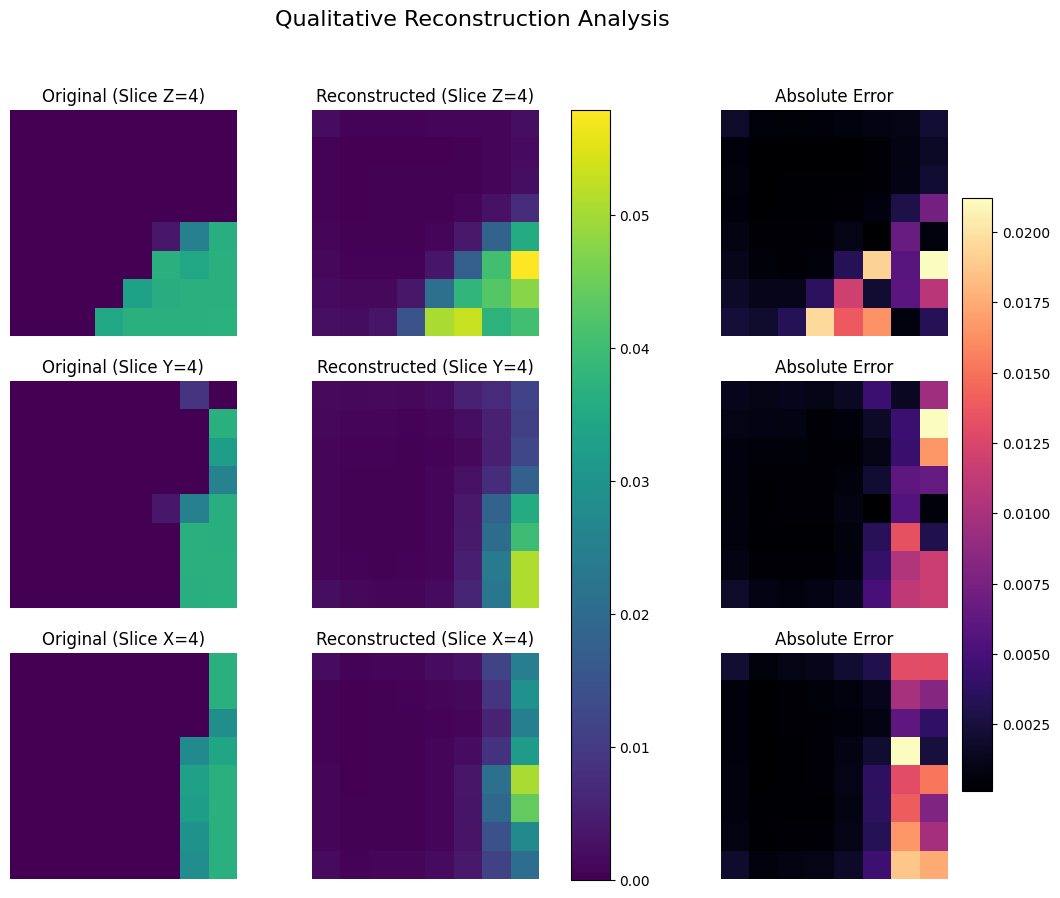

In [4]:
print("Visualizing Reconstruction Quality for a Single Example")

# Save the model state_dict
model_path = "C:/Users/zphrfx/Desktop/hdk/VQVDB/models/good_vqvae.pth"

# Visualize the reconstruction quality for a single example
save = torch.load(model_path, map_location=device)
model.load_state_dict(save)
# Ensure the model is in evaluation mode
model.eval()

# Get a random block from the dataset
original_block = vdb_dataset[45].unsqueeze(0).to(device)

# Perform the full compression/decompression cycle
indices = model.encode(original_block)
reconstructed_block = model.decode(indices)

# Detach from GPU and convert to numpy for plotting
original_np = original_block.squeeze().cpu().numpy()
reconstructed_np = reconstructed_block.squeeze().detach().cpu().numpy()
error_np = np.abs(original_np - reconstructed_np)

# Get consistent color limits for fair comparison
vmin = min(original_np.min(), reconstructed_np.min())
vmax = max(original_np.max(), reconstructed_np.max())

# --- Plot 1: Slice-by-Slice Comparison ---
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
center_slice_idx = 4  # Center slice for visualization
im1 = axes[0, 0].imshow(original_np[center_slice_idx, :, :], vmin=vmin, vmax=vmax, cmap='viridis')
axes[0, 0].set_title(f'Original (Slice Z={center_slice_idx})')
axes[0, 0].axis('off')
# Reconstructed (Z=4)
im2 = axes[0, 1].imshow(reconstructed_np[center_slice_idx, :, :], vmin=vmin, vmax=vmax, cmap='viridis')
axes[0, 1].set_title(f'Reconstructed (Slice Z={center_slice_idx})')
axes[0, 1].axis('off')
# Error Map (Z=4)
im3 = axes[0, 2].imshow(error_np[center_slice_idx, :, :], cmap='magma')
axes[0, 2].set_title('Absolute Error')
axes[0, 2].axis('off')

# --- Row 2: Y-Axis Slice ---
# Original (Y=4)
axes[1, 0].imshow(original_np[:, center_slice_idx, :], vmin=vmin, vmax=vmax, cmap='viridis')
axes[1, 0].set_title(f'Original (Slice Y={center_slice_idx})')
axes[1, 0].axis('off')
# Reconstructed (Y=4)
axes[1, 1].imshow(reconstructed_np[:, center_slice_idx, :], vmin=vmin, vmax=vmax, cmap='viridis')
axes[1, 1].set_title(f'Reconstructed (Slice Y={center_slice_idx})')
axes[1, 1].axis('off')
# Error Map (Y=4)
axes[1, 2].imshow(error_np[:, center_slice_idx, :], cmap='magma')
axes[1, 2].set_title('Absolute Error')
axes[1, 2].axis('off')

# --- Row 3: X-Axis Slice ---
# Original (X=4)
axes[2, 0].imshow(original_np[:, :, center_slice_idx], vmin=vmin, vmax=vmax, cmap='viridis')
axes[2, 0].set_title(f'Original (Slice X={center_slice_idx})')
axes[2, 0].axis('off')
# Reconstructed (X=4)
axes[2, 1].imshow(reconstructed_np[:, :, center_slice_idx], vmin=vmin, vmax=vmax, cmap='viridis')
axes[2, 1].set_title(f'Reconstructed (Slice X={center_slice_idx})')
axes[2, 1].axis('off')
# Error Map (X=4)
axes[2, 2].imshow(error_np[:, :, center_slice_idx], cmap='magma')
axes[2, 2].set_title('Absolute Error')
axes[2, 2].axis('off')

fig.colorbar(im1, ax=axes[:,:2], orientation='vertical', fraction=.1)
fig.colorbar(im3, ax=axes[:,2], orientation='vertical', fraction=.1)
plt.suptitle('Qualitative Reconstruction Analysis', fontsize=16)
plt.show()

In [5]:

# plot losses and perplexity
rl = save['recon_loss_l']
vq_loss_l = save['vq_loss_l']
perplexity_l = save['perplexity_l']

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(rl, label='Reconstruction Loss', color='blue')
plt.plot(vq_loss_l, label='VQ Loss', color='orange')
plt.title('Training Losses')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(perplexity_l, label='Perplexity', color='green')
plt.title('Perplexity Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Perplexity')
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'recon_loss_l'

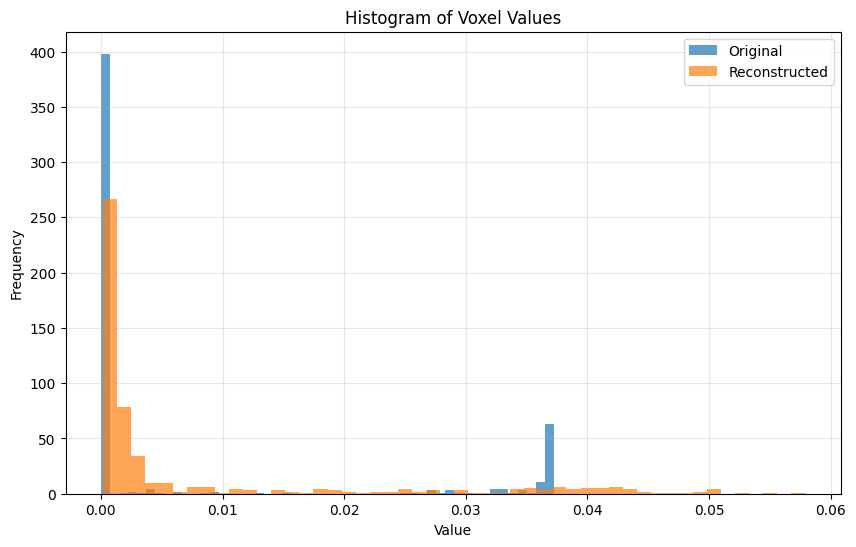

KL Divergence between original and reconstructed blocks: 0.2348


In [6]:
plt.figure(figsize=(10, 6))
plt.hist(original_np.flatten(), bins=50, alpha=0.7, label='Original')
plt.hist(reconstructed_np.flatten(), bins=50, alpha=0.7, label='Reconstructed')
plt.title('Histogram of Voxel Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

from scipy.stats import entropy
def kl_divergence(p, q):
    """Compute KL divergence between two distributions."""
    p = p.flatten()
    q = q.flatten()
    p = p / np.sum(p)  # Normalize
    q = q / np.sum(q)  # Normalize
    return entropy(p, q)
kl_div = kl_divergence(original_np, reconstructed_np)
print(f"KL Divergence between original and reconstructed blocks: {kl_div:.4f}")

PCA of the learned codebook vectors:


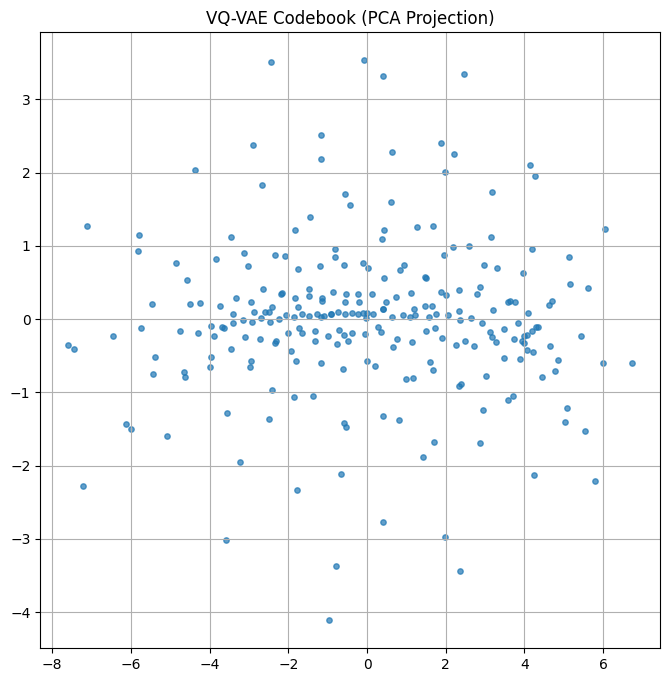


Calculating codebook usage across the entire dataset...


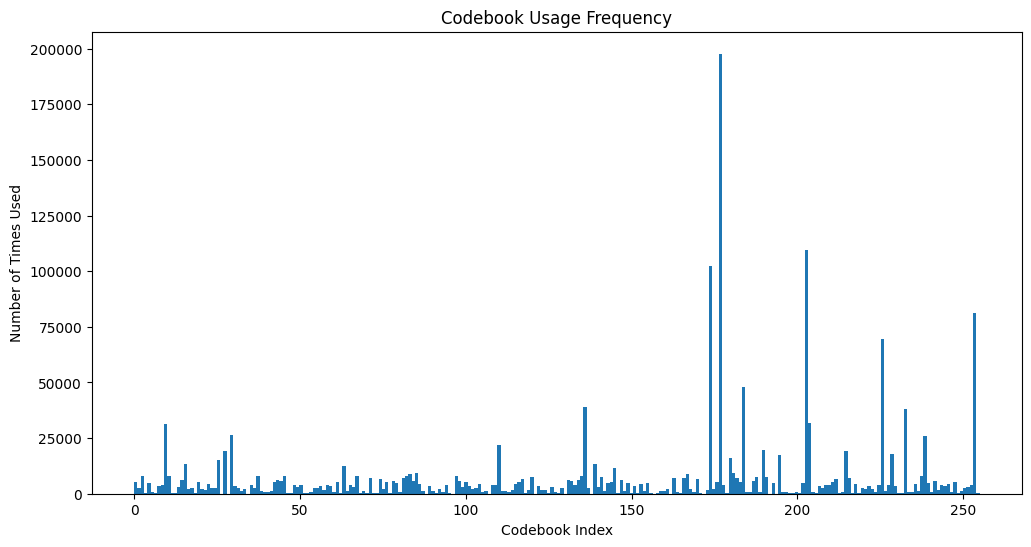

Number of 'dead' (unused) codes: 1 out of 256


In [9]:
print("PCA of the learned codebook vectors:")
codebook = model.quantizer.embedding.data.cpu()
pca = PCA(n_components=2)
codebook_2d = pca.fit_transform(codebook)
plt.figure(figsize=(8, 8))
plt.scatter(codebook_2d[:, 0], codebook_2d[:, 1], s=15, alpha=0.7)
plt.title('VQ-VAE Codebook (PCA Projection)')
plt.grid(True)
plt.show()

# --- Plot 2: Codebook Usage Histogram ---
# This is a powerful diagnostic. It requires running the encoder on the whole dataset.
print("\nCalculating codebook usage across the entire dataset...")
model.eval()
all_indices = []
# Create a dataloader without shuffling to iterate through the dataset
full_loader = DataLoader(vdb_dataset_val, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for data_batch in full_loader:
        data_batch = data_batch.to(device) # Move data to the same device as the model
        indices = model.encode(data_batch)
        all_indices.append(indices.cpu().numpy().flatten())

all_indices = np.concatenate(all_indices)

plt.figure(figsize=(12, 6))
plt.hist(all_indices, bins=NUM_EMBEDDINGS, range=(0, NUM_EMBEDDINGS-1))
plt.title('Codebook Usage Frequency')
plt.xlabel('Codebook Index')
plt.ylabel('Number of Times Used')
plt.show()

num_dead_codes = NUM_EMBEDDINGS - len(np.unique(all_indices))
print(f"Number of 'dead' (unused) codes: {num_dead_codes} out of {NUM_EMBEDDINGS}")

In [10]:
# --- Codebook Perplexity + Active-Code Ratio ---
counts = np.bincount(all_indices, minlength=NUM_EMBEDDINGS).astype(np.float64)
probs = counts / counts.sum()
nonzero = probs > 0
perplexity = np.exp(-(probs[nonzero] * np.log(probs[nonzero])).sum())
active_ratio = nonzero.mean()

print(f"Codebook perplexity: {perplexity:.2f}")
print(f"Active-code ratio  : {active_ratio*100:.1f}%")


Codebook perplexity: 80.05
Active-code ratio  : 99.6%


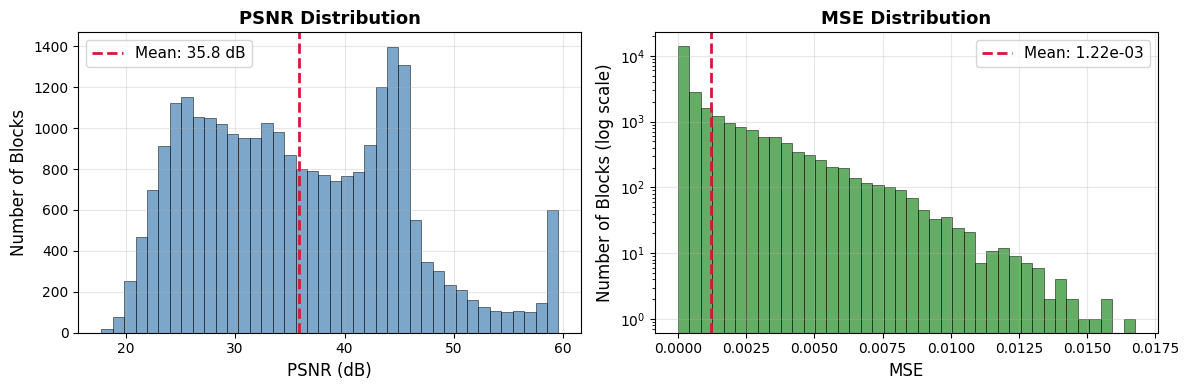

Reconstruction Quality Metrics:
Average PSNR: 35.83 dB
Average MSE: 1.22e-03
PSNR std: 9.32 dB
MSE std: 1.91e-03


In [15]:
from math import log10

def psnr(x, y, vmax=1.0):
    mse = torch.mean((x - y) ** 2).item()
    return 20 * log10(vmax) - 10 * log10(mse + 1e-12)

model.eval()
psnr_list, mse_list = [], []

with torch.no_grad():
    for batch in DataLoader(vdb_dataset_val, batch_size=BATCH_SIZE, shuffle=False):
        batch = batch.to(device)
        rec = model.decode(model.encode(batch))
        mse = ((batch - rec) ** 2).view(len(batch), -1).mean(dim=1)
        mse_list.extend(mse.cpu().numpy())
        psnr_list.extend([psnr(b, r) for b, r in zip(batch, rec)])

avg_psnr = np.mean(psnr_list)
avg_mse = np.mean(mse_list)

# Create publication-ready plots
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# PSNR Distribution
ax1.hist(psnr_list, bins=40, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
ax1.axvline(avg_psnr, color='crimson', linestyle='--', linewidth=2, 
           label=f'Mean: {avg_psnr:.1f} dB')
ax1.set_xlabel('PSNR (dB)', fontsize=12)
ax1.set_ylabel('Number of Blocks', fontsize=12)
ax1.set_title('PSNR Distribution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.tick_params(labelsize=10)

# MSE Distribution
ax2.hist(mse_list, bins=40, alpha=0.7, color='forestgreen', edgecolor='black', linewidth=0.5)
ax2.axvline(avg_mse, color='crimson', linestyle='--', linewidth=2,
           label=f'Mean: {avg_mse:.2e}')
ax2.set_xlabel('MSE', fontsize=12)
ax2.set_ylabel('Number of Blocks (log scale)', fontsize=12)
ax2.set_title('MSE Distribution', fontsize=13, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

print(f"Reconstruction Quality Metrics:")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average MSE: {avg_mse:.2e}")
print(f"PSNR std: {np.std(psnr_list):.2f} dB")
print(f"MSE std: {np.std(mse_list):.2e}")


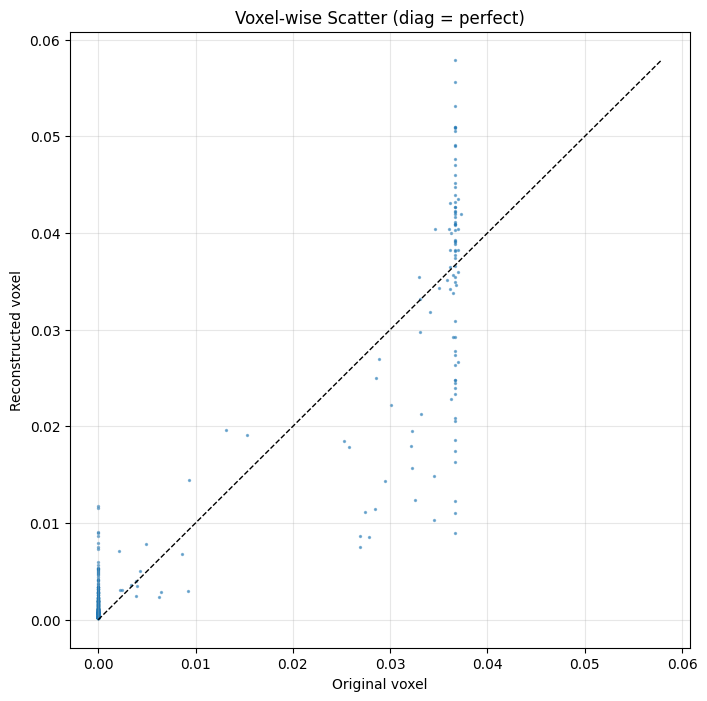

In [17]:
n_points = 100000
orig_sample = original_np.flatten()
recon_sample = reconstructed_np.flatten()
if len(orig_sample) > n_points:
    idx = np.random.choice(len(orig_sample), n_points, replace=False)
    orig_sample = orig_sample[idx]; recon_sample = recon_sample[idx]

plt.figure(figsize=(8,8))
plt.scatter(orig_sample, recon_sample, s=2, alpha=.5)
lims = [min(orig_sample.min(), recon_sample.min()),
        max(orig_sample.max(), recon_sample.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel('Original voxel'); plt.ylabel('Reconstructed voxel')
plt.title('Voxel-wise Scatter (diag = perfect)')
plt.grid(True, alpha=.3); plt.show()


In [ ]:
# --- L2 norm of each embedding vector ---
embed_norm = torch.linalg.norm(model.quantizer.embedding.data, dim=1).cpu().numpy()
plt.figure(figsize=(10,2))
plt.bar(range(NUM_EMBEDDINGS), embed_norm, width=1.0)
plt.title('Codebook Embedding L2 Norms'); plt.xlabel('Code Index'); plt.ylabel('Norm')
plt.tight_layout(); plt.show()


In [ ]:
def mip(vol, axis):
    """Maximum-intensity projection along a single axis."""
    return vol.max(axis=axis)

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
views = [(0, 'XY MIP'),   # collapse Z
         (1, 'XZ MIP'),   # collapse Y
         (2, 'YZ MIP')]   # collapse X

for col, (axis_to_collapse, title) in enumerate(views):
    axes[0, col].imshow(mip(original_np, axis=axis_to_collapse), cmap='viridis')
    axes[0, col].set_title(f'Original {title}')
    axes[0, col].axis('off')

    axes[1, col].imshow(mip(reconstructed_np, axis=axis_to_collapse), cmap='viridis')
    axes[1, col].set_title(f'Reconstructed {title}')
    axes[1, col].axis('off')

plt.suptitle('Maximum-Intensity Projections (3-view)', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# ---------- 1. Build a per-block latent vector ----------
model.eval()
latents, errs = [], []          # errs = optional colouring

with torch.no_grad():
    for batch in DataLoader(vdb_dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=False):
        batch = batch.to(device)
        
        idx = model.encode(batch).long()               # (B, Z, Y, X) indices
        emb = model.quantizer.embedding[idx.view(-1)]  # (B*Z*Y*X, C)
        emb = emb.view(*idx.shape, -1)                 # (B, Z, Y, X, C)
        mean_emb = emb.mean(dim=(1, 2, 3))             # (B, C)
        latents.append(mean_emb.cpu())
        
        # Optional: per-block MSE for coloured scatter
        rec = model.decode(idx)
        errs.append(((batch - rec) ** 2)
                    .view(len(batch), -1)
                    .mean(dim=1)
                    .cpu())

latents = torch.cat(latents, dim=0).numpy()   # (N, C)
errs    = torch.cat(errs, dim=0).numpy()      # (N,)

# ---------- 2. PCA to 2-D ----------
from sklearn.decomposition import FastICA
pca2 = FastICA(n_components=2, random_state=0)
latents_2d = pca2.fit_transform(latents)      # (N, 2)

# ---------- 3. Scatter with viridis ----------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sc = plt.scatter(latents_2d[:, 0],
                 latents_2d[:, 1],
                 c=errs,                 # <- set to None for uniform colour
                 cmap='viridis',
                 s=4,
                 alpha=0.8)
if sc.get_array() is not None:           # only if colouring by a value
    plt.colorbar(sc, label='Block MSE')

plt.title('Latent Space Sampling (PCA-2D, viridis)')
plt.xlabel('PC-1'); plt.ylabel('PC-2')
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()
